<a href="https://colab.research.google.com/github/firhaanali/optimized-sales-forecasting/blob/main/Model_Fix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Package

In [ ]:
!pip install scikit-optimize
!pip install requests
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.9 MB/s eta 0:00:00


# Import Library

In [ ]:
# Import libraries
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import xgboost as xgb
import time
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Suppress warnings
warnings.filterwarnings('ignore')

# Mount Google Drive and load dataset
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Dataset/dataset_merged.xlsx'
df = pd.read_excel(file_path)
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")

Mounted at /content/drive
Dataset loaded with 35940 rows and 24 columns.


# Data Cleaning


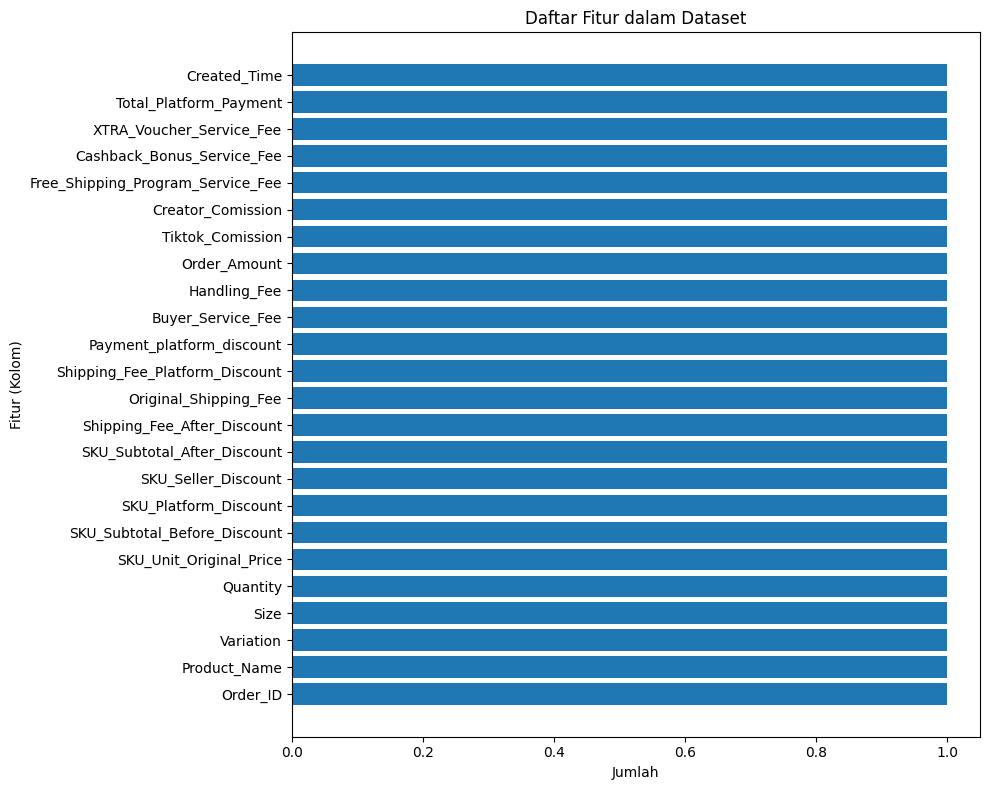

In [ ]:
# Standarisasi nama kolom
original_columns = df.columns.tolist()
df.columns = df.columns.str.strip().str.replace(" ", "_", regex=False)

# Check missing values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

plt.figure(figsize=(10, 8))
plt.barh(range(len(df.columns)), [1]*len(df.columns))  # Membuat semua batang dengan tinggi 1
plt.yticks(range(len(df.columns)), df.columns)
plt.title('Daftar Fitur dalam Dataset')
plt.xlabel('Jumlah')
plt.ylabel('Fitur (Kolom)')
plt.tight_layout()
plt.show()

In [ ]:
# Data Cleaning
df['Size'] = df['Size'].fillna('All_Size').astype(str).str.replace("Ld ", "", case=False).str.strip()
df['Payment_platform_discount'] = pd.to_numeric(df['Payment_platform_discount'], errors='coerce').fillna(0)
df['Handling_Fee'] = pd.to_numeric(df['Handling_Fee'], errors='coerce').fillna(0)

# Feature Engineering

Time Extraction

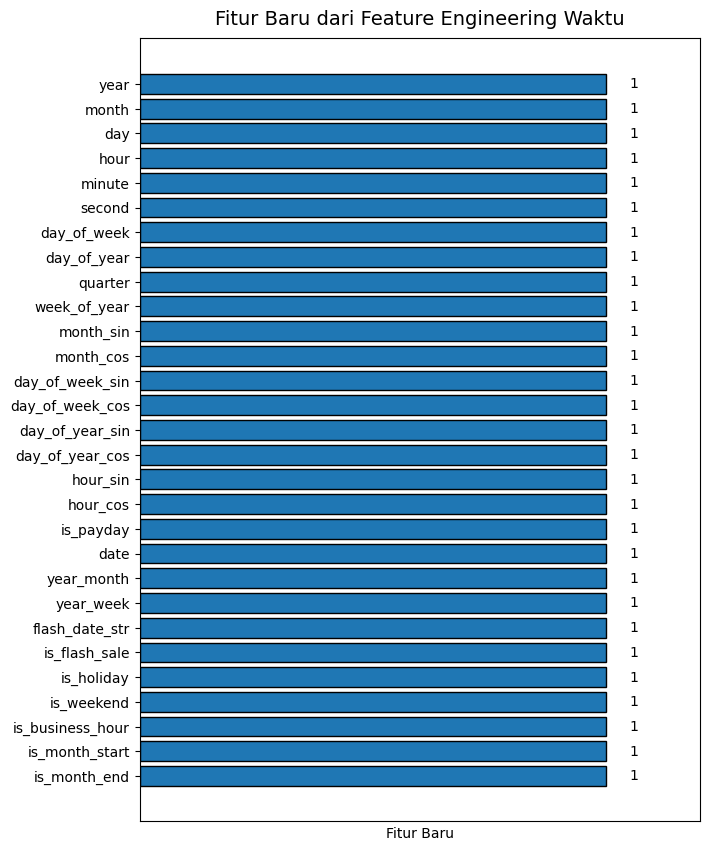

In [ ]:
original_columns = df.columns.tolist()

# Feature Engineering - Time Features
if 'Created_Time' in df.columns:
    df['Created_Time'] = pd.to_datetime(df['Created_Time'], errors='coerce', dayfirst=True)
    df.dropna(subset=['Created_Time'], inplace=True)

# Extract basic time features
df['year'] = df['Created_Time'].dt.year
df['month'] = df['Created_Time'].dt.month
df['day'] = df['Created_Time'].dt.day
df['hour'] = df['Created_Time'].dt.hour
df['minute'] = df['Created_Time'].dt.minute
df['second'] = df['Created_Time'].dt.second
df['day_of_week'] = df['Created_Time'].dt.dayofweek
df['day_of_year'] = df['Created_Time'].dt.dayofyear
df['quarter'] = df['Created_Time'].dt.quarter
df['week_of_year'] = df['Created_Time'].dt.isocalendar().week

# Cyclical transformations
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['day_of_year_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_of_year_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Calendar/event features
df['is_payday'] = df['day'].isin([25, 26, 27, 28, 29, 30, 31, 1, 2]).astype(int)
df['date'] = df['Created_Time'].dt.date
df['year_month'] = df['Created_Time'].dt.strftime('%Y-%m')
df['year_week'] = df['year'].astype(str) + '-' + df['week_of_year'].astype(str).str.zfill(2)

# Flash sale features
flash_dates = [f"{str(i).zfill(2)}-{str(i).zfill(2)}" for i in range(1, 13)]
df['flash_date_str'] = df['month'].astype(str).str.zfill(2) + '-' + df['day'].astype(str).str.zfill(2)
df['is_flash_sale'] = df['flash_date_str'].isin(flash_dates).astype(int)

# National holidays
years = [2022, 2023, 2024, 2025]
holiday_dates = []

for year in years:
    url = f"https://date.nager.at/api/v3/PublicHolidays/{year}/ID"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        for holiday in data:
            holiday_dates.append(holiday['date'])

libur_nasional = pd.to_datetime(holiday_dates)
df['is_holiday'] = df['Created_Time'].dt.date.isin(libur_nasional.date).astype(int)

# Additional flags
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_business_hour'] = (((df['hour'] >= 8) & (df['hour'] <= 17)) & (df['day_of_week'] < 5)).astype(int)
df['is_month_start'] = (df['day'] <= 7).astype(int)
df['is_month_end'] = (df['day'] >= 24).astype(int)

after_time_columns = df.columns.tolist()
added_time_features = [col for col in after_time_columns if col not in original_columns]

# Visualisasi
if added_time_features:
    fig, ax = plt.subplots(figsize=(8, len(added_time_features) * 0.3))
    bars = ax.barh(added_time_features, [1]*len(added_time_features), edgecolor='black')

    for bar in bars:
        ax.text(1.05, bar.get_y() + bar.get_height()/2, '1', va='center', fontsize=10)

    ax.set_title('Fitur Baru dari Feature Engineering Waktu', fontsize=14, pad=10)
    ax.set_xlabel('Fitur Baru')
    ax.set_xlim(0, 1.2)
    ax.set_xticks([])
    ax.invert_yaxis()
    plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)
    plt.grid(False)
    plt.show()


Time - Series

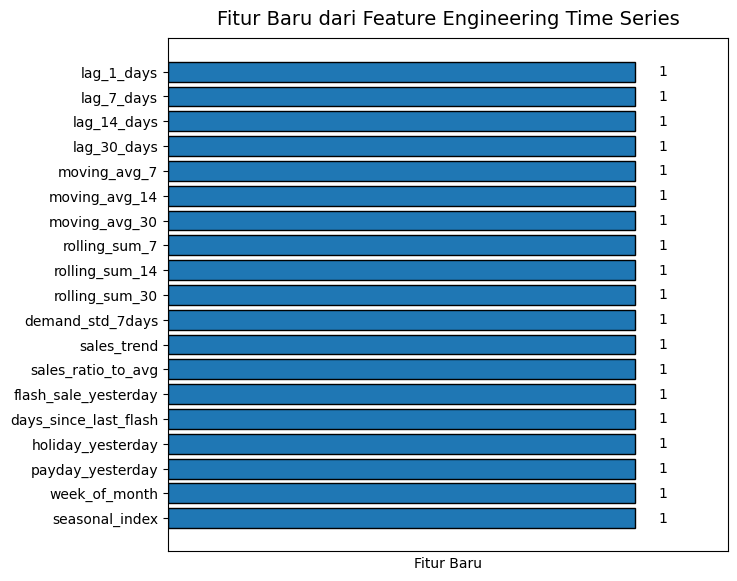

In [ ]:
# Feature Engineering - Time Series Features
df = df.sort_values('Created_Time')
df['date'] = df['Created_Time'].dt.date

if 'Product_Name' in df.columns and 'Created_Time' in df.columns:
    # Daily sales aggregation per product
    daily_sales = df.groupby(['Product_Name', 'date'])['Quantity'].sum().reset_index()
    daily_sales = daily_sales.sort_values(['Product_Name', 'date'])

    # Create lag features
    for lag in [1, 7, 14, 30]:
        daily_sales[f'lag_{lag}_days'] = daily_sales.groupby('Product_Name')['Quantity'].shift(lag)

    # Moving Averages & Rolling Sum
    for window in [7, 14, 30]:
        daily_sales[f'moving_avg_{window}'] = daily_sales.groupby('Product_Name')['Quantity'].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        daily_sales[f'rolling_sum_{window}'] = daily_sales.groupby('Product_Name')['Quantity'].transform(
            lambda x: x.rolling(window=window, min_periods=1).sum()
        )

    # Merge time series features to main dataframe
    df = pd.merge(
        df,
        daily_sales[['Product_Name', 'date'] +
                    [f'lag_{lag}_days' for lag in [1, 7, 14, 30]] +
                    [f'moving_avg_{window}' for window in [7, 14, 30]] +
                    [f'rolling_sum_{window}' for window in [7, 14, 30]]],
        on=['Product_Name', 'date'],
        how='left'
    )

    # Volatility features
    df['demand_std_7days'] = daily_sales.groupby('Product_Name')['Quantity'].transform(
        lambda x: x.rolling(window=7, min_periods=1).std()
    )

    # Sales trends and ratios
    df['sales_trend'] = (df['lag_7_days'] - df['lag_14_days']) / (df['lag_14_days'] + 1) * 100
    df['sales_ratio_to_avg'] = df['Quantity'] / (df['moving_avg_30'] + 1)

# Flash sale features
df['flash_sale_yesterday'] = df.groupby('Product_Name')['is_flash_sale'].shift(1).fillna(0)
df['days_since_last_flash'] = (
    df[::-1].groupby('Product_Name')['is_flash_sale']
    .apply(lambda x: x.cumsum().shift(-1).fillna(0))
    .reset_index(level=0, drop=True)[::-1]
)

# Holiday and payday features
df['holiday_yesterday'] = df['is_holiday'].shift(1).fillna(0)
df['payday_yesterday'] = df['is_payday'].shift(1).fillna(0)

# Additional time features
df['week_of_month'] = pd.to_datetime(df['date']).dt.day.apply(lambda d: (d - 1) // 7 + 1)

# Monthly seasonal index
if 'month' in df.columns:
    # Calculate monthly average per product
    monthly_avg = df.groupby(['Product_Name', 'month'])['Quantity'].mean().reset_index()

    # Calculate overall average per product
    product_avg = monthly_avg.groupby('Product_Name')['Quantity'].mean().reset_index()

    # Join to calculate seasonal index
    monthly_avg = pd.merge(monthly_avg, product_avg, on='Product_Name', suffixes=('_month', '_product'))
    monthly_avg['seasonal_index'] = monthly_avg['Quantity_month'] / monthly_avg['Quantity_product']

    # Join seasonal index to main dataframe
    df = pd.merge(df, monthly_avg[['Product_Name', 'month', 'seasonal_index']],
                  on=['Product_Name', 'month'], how='left')

# Fill NaN values for all time series features
ts_columns = [col for col in df.columns if 'lag_' in col or 'moving_avg_' in col or
              'trend' in col or 'ratio' in col or 'seasonal' in col or
              'std' in col or 'flash' in col or 'holiday_yesterday' in col or
              'payday_yesterday' in col]
for col in ts_columns:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# Drop and Save
created_times = df['Created_Time'].copy()
product_names = df['Product_Name'].copy()
variations = df['Variation'].copy() if 'Variation' in df.columns else None
sizes = df['Size'].copy() if 'Size' in df.columns else None

# Drop non-feature columns
df.drop(columns=['Created_Time', 'date', 'year_month', 'year_week'], inplace=True, errors='ignore')
df.drop(columns=['Product_Name', 'Variation', 'Size'], inplace=True, errors='ignore')

after_ts_columns = df.columns.tolist()
added_ts_features = [col for col in after_ts_columns if col not in after_time_columns]

# Visualisasi
if added_ts_features:
    fig, ax = plt.subplots(figsize=(8, len(added_ts_features) * 0.3))
    bars = ax.barh(added_ts_features, [1]*len(added_ts_features), edgecolor='black')

    for bar in bars:
        ax.text(1.05, bar.get_y() + bar.get_height()/2, '1', va='center', fontsize=10)

    ax.set_title('Fitur Baru dari Feature Engineering Time Series', fontsize=14, pad=10)
    ax.set_xlabel('Fitur Baru')
    ax.set_xlim(0, 1.2)
    ax.set_xticks([])
    ax.invert_yaxis()
    plt.subplots_adjust(left=0.25, right=0.95, top=0.95, bottom=0.05)
    plt.grid(False)
    plt.show()

# Data Split

Distribusi Jumlah Data:
Training	: 28752 sampel (80.0%)
Validation	: 3594 sampel (10.0%)
Testing		: 3594 sampel (10.0%)
Total		: 35940 sampel (100%)


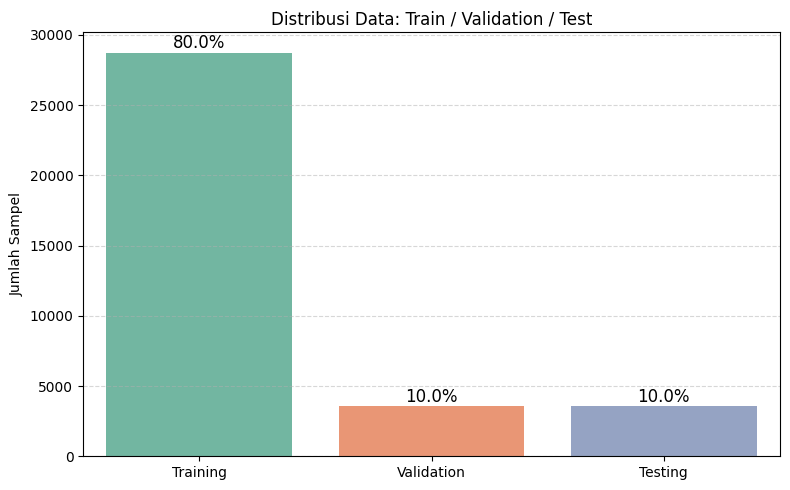

In [ ]:
# Train-Validation-Test Split
target_column = 'Quantity'
columns_to_drop = ['year_month', 'date', 'flash_date_str']

# Separate features and target
X = df.drop(columns=[target_column] + [col for col in columns_to_drop if col in df.columns])
y = np.log1p(df[target_column])  # Log transform for better model performance

# Time-based split
train_size = int(0.8 * len(df))
valid_size = int(0.1 * len(df))

X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]
X_valid = X.iloc[train_size:train_size+valid_size]
y_valid = y.iloc[train_size:train_size+valid_size]
X_test = X.iloc[train_size+valid_size:]
y_test = y.iloc[train_size+valid_size:]

# Hitung jumlah sampel
counts = [len(X_train), len(X_valid), len(X_test)]
labels = ['Training', 'Validation', 'Testing']
percentages = [count / (len(X_train) + len(X_valid) + len(X_test)) * 100 for count in counts]

# Visualisasi
print("Distribusi Jumlah Data:")
print(f"Training\t: {counts[0]} sampel ({percentages[0]:.1f}%)")
print(f"Validation\t: {counts[1]} sampel ({percentages[1]:.1f}%)")
print(f"Testing\t\t: {counts[2]} sampel ({percentages[2]:.1f}%)")
print(f"Total\t\t: {sum(counts)} sampel (100%)")

plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=counts, hue=labels, palette='Set2', legend=False)

for i, (count, pct) in enumerate(zip(counts, percentages)):
    plt.text(i, count + 5, f'{pct:.1f}%', ha='center', va='bottom', fontsize=12)

plt.title('Distribusi Data: Train / Validation / Test')
plt.ylabel('Jumlah Sampel')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Mean Importance Score: 0.0159
Selected 6 features from total 63 initial features.


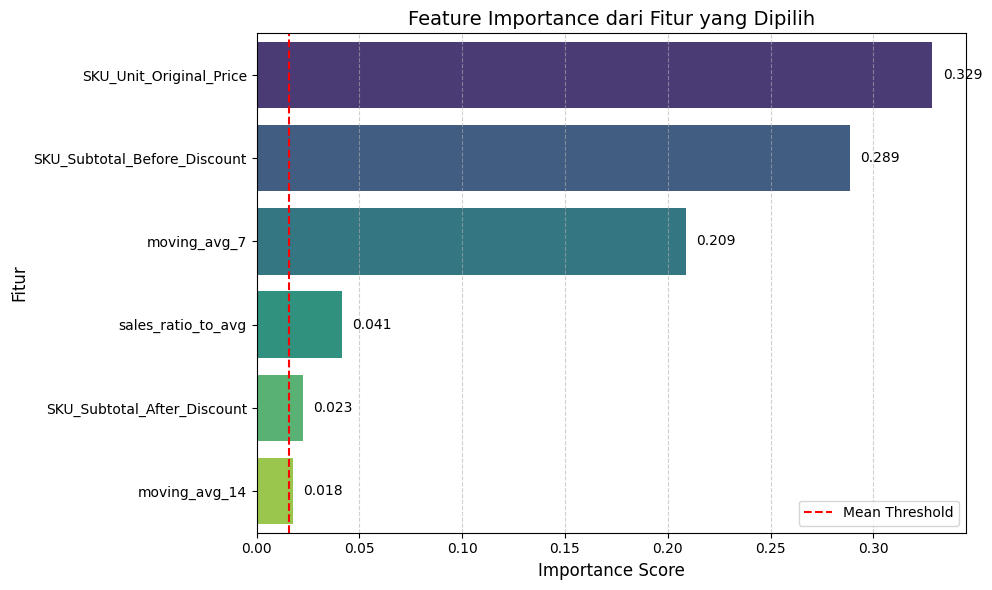

✅ Terpilih 6 fitur dari total 6 fitur awal.


In [ ]:
# Feature Selection
feature_selector = xgb.XGBRegressor(random_state=42)
feature_selector.fit(X_train, y_train)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_selector.feature_importances_
})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

importance_mean = feature_importance['Importance'].mean()
print(f"Mean Importance Score: {importance_mean:.4f}")

selector = SelectFromModel(feature_selector, threshold=importance_mean, prefit=True)
selected_features = X_train.columns[selector.get_support()]
print(f"Selected {len(selected_features)} features from total {X_train.shape[1]} initial features.")

# Use selected features for all data subsets
X_train = X_train[selected_features]
X_valid = X_valid[selected_features]
X_test = X_test[selected_features]

# Filter hanya fitur yang dipilih
selected_feature_importance = feature_importance[feature_importance['Feature'].isin(selected_features)]

# Visualisasi
plt.figure(figsize=(10, 6))
sns.barplot(
    data=selected_feature_importance,
    x='Importance',
    y='Feature',
    hue='Feature',
    dodge=False,
    palette='viridis',
    legend=False
)

# Tambahkan nilai pada setiap batang
for i, val in enumerate(selected_feature_importance['Importance']):
    plt.text(val + 0.005, i, f"{val:.3f}", va='center')

plt.axvline(importance_mean, color='red', linestyle='--', label='Mean Threshold')
plt.title('Feature Importance dari Fitur yang Dipilih', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.legend()
plt.show()

print(f"✅ Terpilih {len(selected_features)} fitur dari total {X_train.shape[1]} fitur awal.")

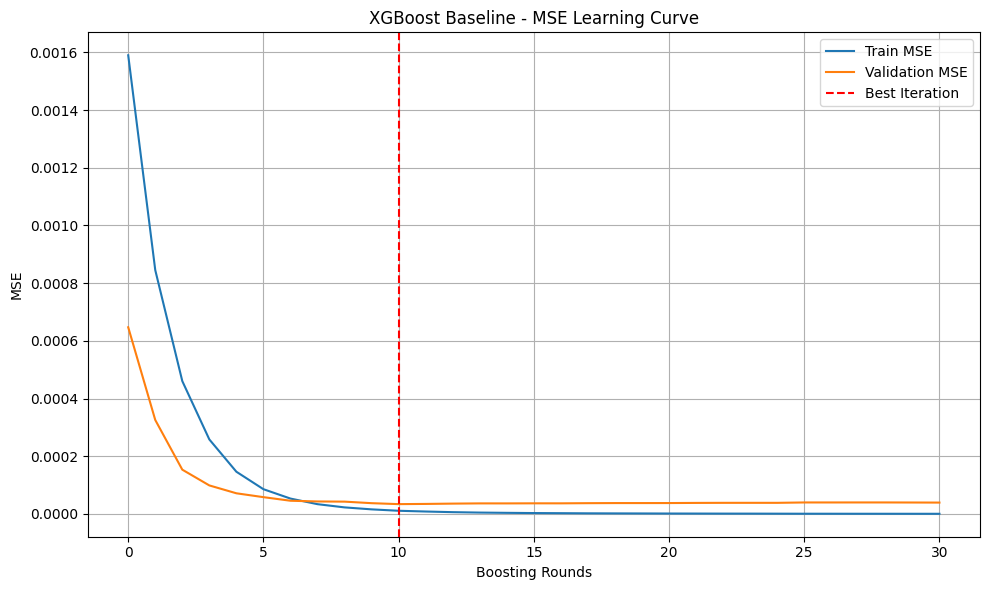

In [ ]:
# Baseline Model
model_baseline = xgb.XGBRegressor(random_state=42, eval_metric=["rmse"])

# Create DMatrix for training and validation
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Set basic model parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': 42
}

# Prepare eval_set and evaluation results dictionary
evals = [(dtrain, 'train'), (dvalid, 'valid')]
evals_result = {}

# Train with early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=False
)

# 5. Ambil RMSE dan konversi ke MSE
rmse_train = np.array(evals_result['train']['rmse'])
rmse_valid = np.array(evals_result['valid']['rmse'])
mse_train = rmse_train ** 2
mse_valid = rmse_valid ** 2

# 6. Visualisasi Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(mse_train, label='Train MSE')
plt.plot(mse_valid, label='Validation MSE')
plt.axvline(x=model.best_iteration, color='r', linestyle='--', label='Best Iteration')
plt.title("XGBoost Baseline - MSE Learning Curve")
plt.xlabel("Boosting Rounds")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Hyperparameter Tuning with Bayesian Optimization
param_bayes = {
    'max_depth': Integer(3, 10),
    'learning_rate': Real(0.001, 1, prior='log-uniform'),
    'n_estimators': Integer(50, 500),
    'subsample': Real(0.1, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.1, 1.0, prior='uniform'),
}

model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    verbosity=0
)

tscv = TimeSeriesSplit(n_splits=5)

bayes_search = BayesSearchCV(
    estimator=model_xgb,
    search_spaces=param_bayes,
    n_iter=100,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    verbose=3,
    random_state=42,
    return_train_score=True
)

print("Starting parameter search with Bayesian Optimization...")
start_bayes = time.time()
bayes_search.fit(X_train, y_train)
end_bayes = time.time()
print(f"Completed in {(end_bayes - start_bayes) / 60:.2f} minutes.")

# Save best model from Bayesian Optimization
model_optimized = bayes_search.best_estimator_

# Get best parameters
best_params = bayes_search.best_params_
print("\nOptimal Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Set parameters from Bayesian Optimization
params = bayes_search.best_params_
params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 0,
    'random_state': 42
})

# Prepare eval list and results dictionary
evals = [(dtrain, 'train'), (dvalid, 'valid')]
evals_result = {}

# Train model with early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=False
)

Starting parameter search with Bayesian Optimization...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.46909356296798244, learning_rate=0.15246748254295628, max_depth=10, n_estimators=192, subsample=0.7031331534420412;, score=(train=-0.000, test=-0.003) total time=   5.1s
[CV 2/5] END colsample_bytree=0.46909356296798244, learning_rate=0.15246748254295628, max_depth=10, n_estimators=192, subsample=0.7031331534420412;, score=(train=-0.000, test=-0.001) total time=   7.9s
[CV 3/5] END colsample_bytree=0.46909356296798244, learning_rate=0.15246748254295628, max_depth=10, n_estimators=192, subsample=0.7031331534420412;, score=(train=-0.000, test=-0.004) total time=   0.5s
[CV 4/5] END colsample_bytree=0.46909356296798244, learning_rate=0.15246748254295628, max_depth=10, n_estimators=192, subsample=0.7031331534420412;, score=(train=-0.000, test=-0.006) total time=   0.6s
[CV 5/5] END colsample_bytree=0.46909356296798244, learning_rate=0.1524674825

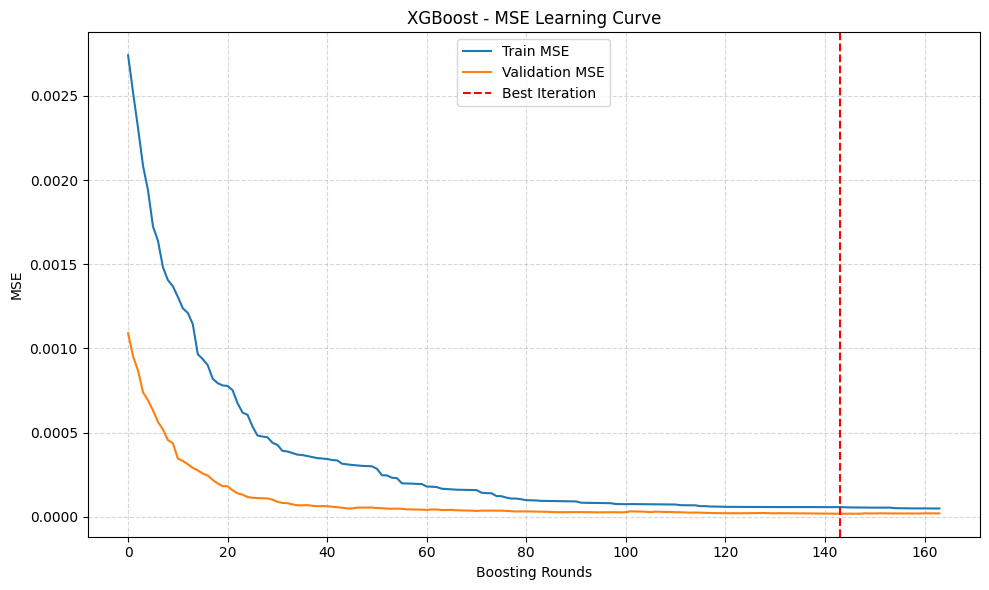

In [ ]:
# Siapkan DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# Parameter hasil Bayesian Optimization
params = bayes_search.best_params_
params.update({
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'verbosity': 0,
    'random_state': 42
})

# Siapkan list eval dan dictionary untuk menyimpan hasil
evals = [(dtrain, 'train'), (dvalid, 'valid')]
evals_result = {}

# Train model dengan early stopping
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=20,
    evals_result=evals_result,
    verbose_eval=False
)

# Ambil dan konversi RMSE ke MSE
rmse_train = np.array(evals_result['train']['rmse'])
rmse_valid = np.array(evals_result['valid']['rmse'])
mse_train = rmse_train ** 2
mse_valid = rmse_valid ** 2

# Visualisasi Learning Curve
plt.figure(figsize=(10, 6))
plt.plot(mse_train, label='Train MSE')
plt.plot(mse_valid, label='Validation MSE')
plt.axvline(x=model.best_iteration, color='r', linestyle='--', label='Best Iteration')
plt.title("XGBoost - MSE Learning Curve")
plt.xlabel("Boosting Rounds")
plt.ylabel("MSE")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

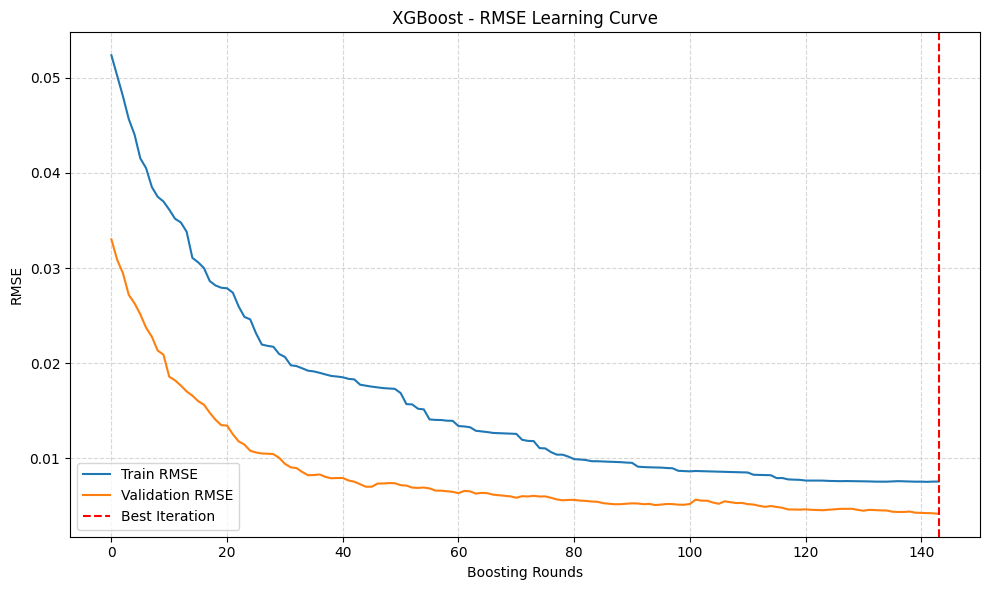

In [ ]:
# Hitung RMSE di setiap boosting round
rmse_train_curve = []
rmse_valid_curve = []

for i in range(1, model.best_iteration + 2):
    y_pred_train_i = model.predict(dtrain, iteration_range=(0, i))
    y_pred_valid_i = model.predict(dvalid, iteration_range=(0, i))
    rmse_train_curve.append(np.sqrt(mean_squared_error(y_train, y_pred_train_i)))
    rmse_valid_curve.append(np.sqrt(mean_squared_error(y_valid, y_pred_valid_i)))

# Plot Learning Curve RMSE
plt.figure(figsize=(10, 6))
plt.plot(rmse_train_curve, label='Train RMSE')
plt.plot(rmse_valid_curve, label='Validation RMSE')
plt.axvline(x=model.best_iteration, color='r', linestyle='--', label='Best Iteration')
plt.title("XGBoost - RMSE Learning Curve")
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

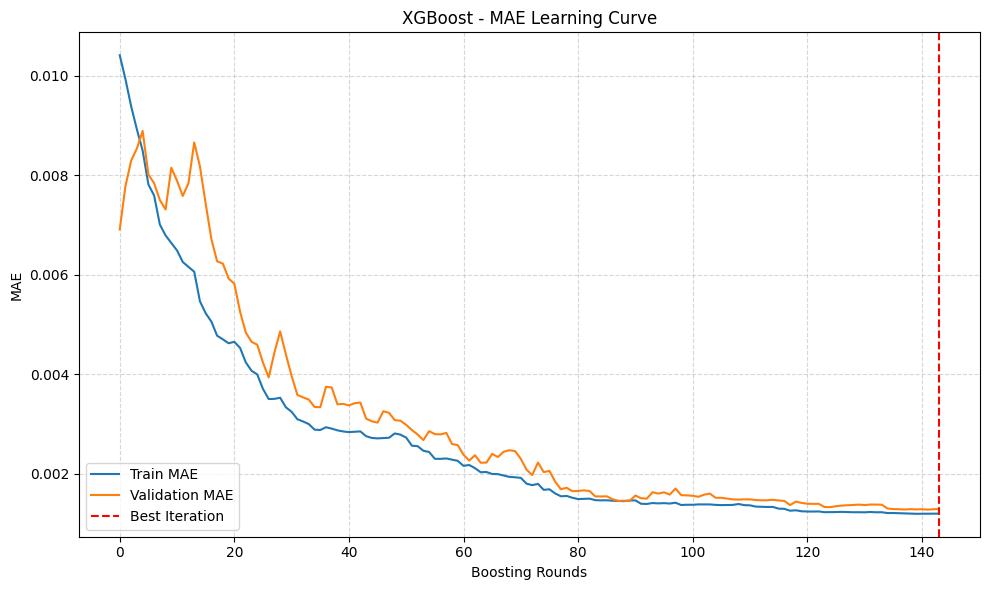

In [ ]:
# Hitung MAE di setiap boosting round
mae_train = []
mae_valid = []

for i in range(1, model.best_iteration + 2):
    y_pred_train_i = model.predict(dtrain, iteration_range=(0, i))
    y_pred_valid_i = model.predict(dvalid, iteration_range=(0, i))
    mae_train.append(mean_absolute_error(y_train, y_pred_train_i))
    mae_valid.append(mean_absolute_error(y_valid, y_pred_valid_i))

# Plot Learning Curve MAE
plt.figure(figsize=(10, 6))
plt.plot(mae_train, label='Train MAE')
plt.plot(mae_valid, label='Validation MAE')
plt.axvline(x=model.best_iteration, color='r', linestyle='--', label='Best Iteration')
plt.title("XGBoost - MAE Learning Curve")
plt.xlabel("Boosting Rounds")
plt.ylabel("MAE")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

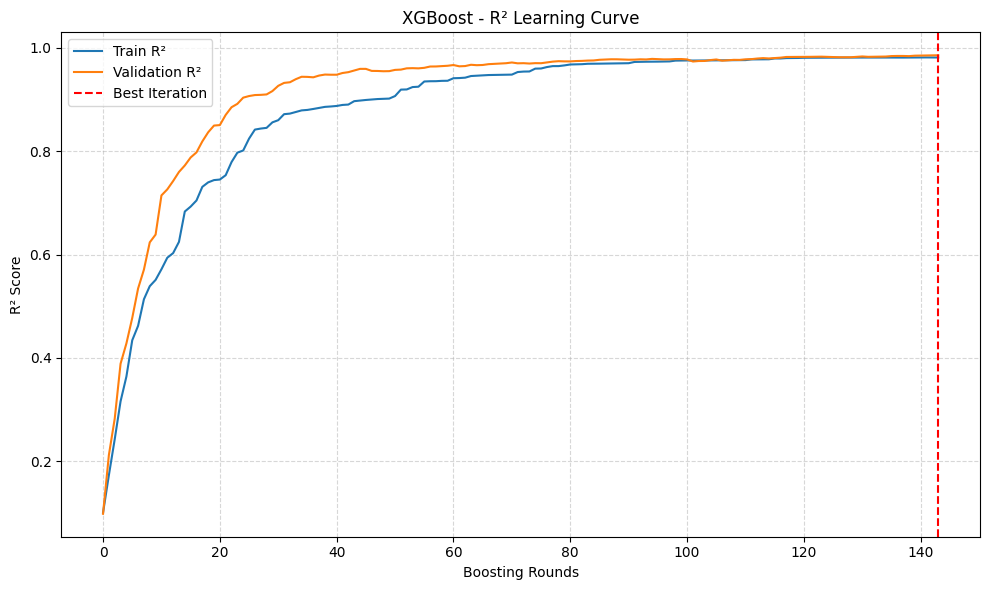

In [ ]:
# Hitung R² di setiap boosting round
r2_train = []
r2_valid = []

for i in range(1, model.best_iteration + 2):
    y_pred_train_i = model.predict(dtrain, iteration_range=(0, i))
    y_pred_valid_i = model.predict(dvalid, iteration_range=(0, i))
    r2_train.append(r2_score(y_train, y_pred_train_i))
    r2_valid.append(r2_score(y_valid, y_pred_valid_i))

# Plot Learning Curve R²
plt.figure(figsize=(10, 6))
plt.plot(r2_train, label='Train R²')
plt.plot(r2_valid, label='Validation R²')
plt.axvline(x=model.best_iteration, color='r', linestyle='--', label='Best Iteration')
plt.title("XGBoost - R² Learning Curve")
plt.xlabel("Boosting Rounds")
plt.ylabel("R² Score")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Gunakan kembali model hasil optimasi
final_model_cv = xgb.XGBRegressor(**model_optimized.get_params())

# Setup TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# List untuk menyimpan hasil setiap fold
mse_list, rmse_list, mae_list, r2_list = [], [], [], []

# Cross-validation manual
for fold, (train_idx, test_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[test_idx]

    final_model_cv.fit(X_tr, y_tr)
    y_pred = final_model_cv.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    mse_list.append(mse)
    rmse_list.append(rmse)
    mae_list.append(mae)
    r2_list.append(r2)

    print(f"Fold {fold+1}: MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}, R²={r2:.4f}")

# Rata-rata hasil cross-validation
print("\n=== Rata-Rata Evaluasi Cross-Validation ===")
print(f"Average MSE : {np.mean(mse_list):.4f}")
print(f"Average RMSE: {np.mean(rmse_list):.4f}")
print(f"Average MAE : {np.mean(mae_list):.4f}")
print(f"Average R²  : {np.mean(r2_list):.4f}")

Fold 1: MSE=0.0002, RMSE=0.0148, MAE=0.0067, R²=0.8534
Fold 2: MSE=0.0002, RMSE=0.0130, MAE=0.0026, R²=0.9188
Fold 3: MSE=0.0001, RMSE=0.0089, MAE=0.0019, R²=0.9608
Fold 4: MSE=0.0001, RMSE=0.0118, MAE=0.0032, R²=0.9385
Fold 5: MSE=0.0005, RMSE=0.0220, MAE=0.0043, R²=0.8312

=== Rata-Rata Evaluasi Cross-Validation ===
Average MSE : 0.0002
Average RMSE: 0.0141
Average MAE : 0.0037
Average R²  : 0.9005


In [ ]:
# Predictions
model_baseline.fit(X_train, y_train)
y_pred_test_baseline = model_baseline.predict(X_test)
y_pred_test_bo = model_optimized.predict(X_test)

# Model Evaluation
models_metrics = {
    'Baseline': {
        'MSE': mean_squared_error(y_test, y_pred_test_baseline),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_baseline)),
        'MAE': mean_absolute_error(y_test, y_pred_test_baseline),
        'R²': r2_score(y_test, y_pred_test_baseline)
    },
    'BayesianOpt': {
        'MSE': mean_squared_error(y_test, y_pred_test_bo),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test_bo)),
        'MAE': mean_absolute_error(y_test, y_pred_test_bo),
        'R²': r2_score(y_test, y_pred_test_bo)
    }
}

# Display comparison table
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Baseline': [models_metrics['Baseline']['MSE'],
                 models_metrics['Baseline']['RMSE'],
                 models_metrics['Baseline']['MAE'],
                 models_metrics['Baseline']['R²']],
    'BayesianOpt': [models_metrics['BayesianOpt']['MSE'],
                    models_metrics['BayesianOpt']['RMSE'],
                    models_metrics['BayesianOpt']['MAE'],
                    models_metrics['BayesianOpt']['R²']]
}).round(4)

print("\n=== METRIC COMPARISON (Baseline vs Bayesian Optimization) ===")
print(metrics_df.to_string(index=False))

# Calculate relative improvement percentage
improvement_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'BayesianOpt vs Baseline (%)': [
        (models_metrics['Baseline']['MSE'] - models_metrics['BayesianOpt']['MSE']) / models_metrics['Baseline']['MSE'] * 100,
        (models_metrics['Baseline']['RMSE'] - models_metrics['BayesianOpt']['RMSE']) / models_metrics['Baseline']['RMSE'] * 100,
        (models_metrics['Baseline']['MAE'] - models_metrics['BayesianOpt']['MAE']) / models_metrics['Baseline']['MAE'] * 100,
        (models_metrics['BayesianOpt']['R²'] - models_metrics['Baseline']['R²']) / abs(models_metrics['Baseline']['R²']) * 100 if models_metrics['Baseline']['R²'] != 0 else float('inf')
    ]
}).round(2)

print("\n=== RELATIVE IMPROVEMENT (BayesianOpt vs Baseline) ===")
print(improvement_df.to_string(index=False))


=== METRIC COMPARISON (Baseline vs Bayesian Optimization) ===
Metric  Baseline  BayesianOpt
   MSE    0.0006       0.0002
  RMSE    0.0241       0.0126
   MAE    0.0016       0.0037
    R²    0.8916       0.9704

=== RELATIVE IMPROVEMENT (BayesianOpt vs Baseline) ===
Metric  BayesianOpt vs Baseline (%)
   MSE                        72.69
  RMSE                        47.74
   MAE                      -136.29
    R²                         8.84


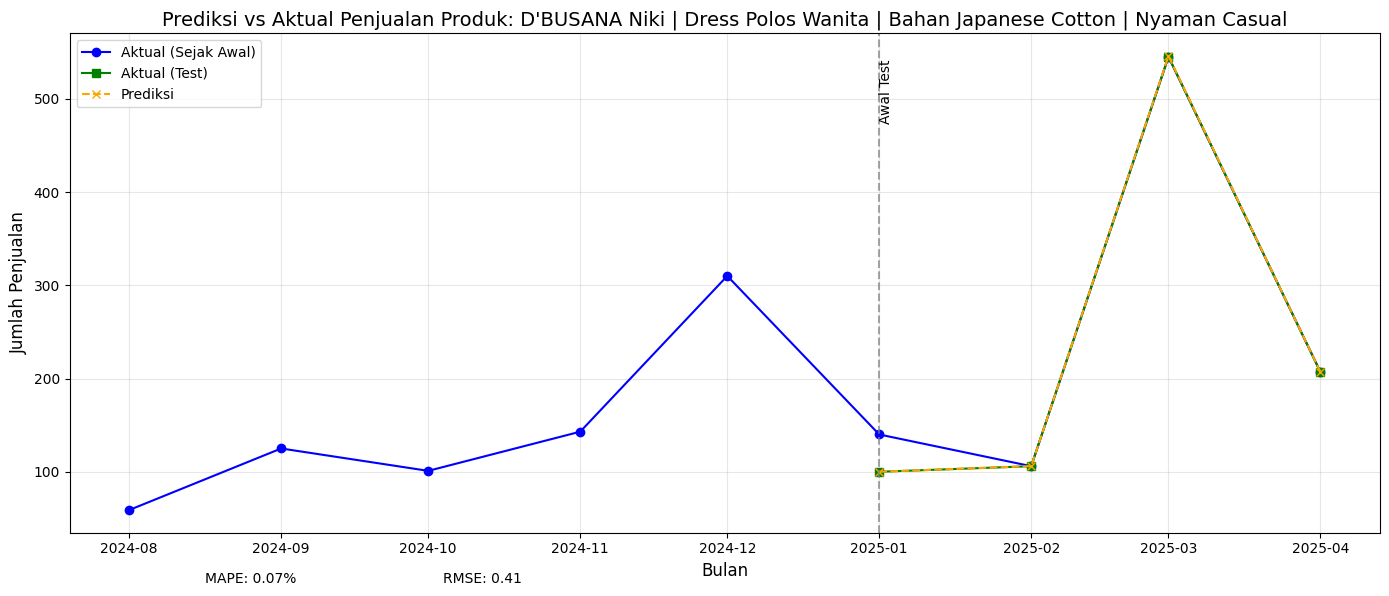

Jumlah bulan dalam data penuh: 9
Jumlah bulan dalam data test: 4
Jumlah transaksi dalam data test untuk produk ini: 950

Pola Bulanan:
year_month  Actual_Sales_Full  Actual_Sales  Predicted_Sales
   2024-08                 59           NaN              NaN
   2024-09                125           NaN              NaN
   2024-10                101           NaN              NaN
   2024-11                143           NaN              NaN
   2024-12                310           NaN              NaN
   2025-01                140         100.0       100.032173
   2025-02                106         106.0       106.072029
   2025-03                545         545.0       545.812927
   2025-04                207         207.0       207.087540


In [ ]:
# Siapkan data test
product_names_test = product_names.iloc[train_size + valid_size:].reset_index(drop=True)
test_dates = created_times.iloc[train_size + valid_size:].reset_index(drop=True)

# Transformasi balik dari log1p
actual_sales = np.expm1(y_test)
predicted_sales = np.expm1(y_pred_test_bo)

# Buat DataFrame prediksi
valid_len = len(y_test)
prediction_df = pd.DataFrame({
    'Product_Name': product_names_test[-valid_len:].reset_index(drop=True),
    'Tanggal': pd.to_datetime(test_dates[-valid_len:]).reset_index(drop=True),
    'Actual_Sales': actual_sales.values,
    'Predicted_Sales': predicted_sales
})

# Ambil 1 produk terlaris dari test set
top_product = prediction_df['Product_Name'].value_counts().idxmax()

# Agregasi data asli per bulan
product_idx = product_names == top_product
produk_full = pd.DataFrame({
    'Product_Name': [top_product] * sum(product_idx),
    'Created_Time': pd.to_datetime(created_times[product_idx].reset_index(drop=True)),
    'Quantity': df.loc[product_idx, target_column].reset_index(drop=True)
})

produk_full['year_month'] = produk_full['Created_Time'].dt.to_period('M')
produk_actual_agg = produk_full.groupby('year_month')['Quantity'].sum().reset_index()
produk_actual_agg.rename(columns={'Quantity': 'Actual_Sales_Full'}, inplace=True)

# Agregasi data prediksi test
produk_pred_raw = prediction_df[prediction_df['Product_Name'] == top_product].copy()
produk_pred_raw['year_month'] = produk_pred_raw['Tanggal'].dt.to_period('M')

produk_pred_agg = produk_pred_raw.groupby('year_month').agg({
    'Actual_Sales': 'sum',
    'Predicted_Sales': 'sum'
}).reset_index()

# Gabungkan data
produk_actual_agg['year_month_str'] = produk_actual_agg['year_month'].astype(str)
produk_pred_agg['year_month_str'] = produk_pred_agg['year_month'].astype(str)

produk_combined = pd.merge(
    produk_actual_agg,
    produk_pred_agg,
    on='year_month_str',
    how='outer'
)

produk_combined['year_month'] = produk_combined['year_month_x'].fillna(produk_combined['year_month_y'])
produk_combined = produk_combined.sort_values('year_month')

# Visualisasi perbandingan prediksi dengan aktual
plt.figure(figsize=(14, 6))

valid_full = ~produk_combined['Actual_Sales_Full'].isna()
plt.plot(produk_combined.loc[valid_full, 'year_month'].dt.to_timestamp(),
         produk_combined.loc[valid_full, 'Actual_Sales_Full'],
         label='Aktual (Sejak Awal)', marker='o', color='blue')

valid_test = ~produk_combined['Actual_Sales'].isna()
plt.plot(produk_combined.loc[valid_test, 'year_month'].dt.to_timestamp(),
         produk_combined.loc[valid_test, 'Actual_Sales'],
         label='Aktual (Test)', marker='s', color='green')

valid_pred = ~produk_combined['Predicted_Sales'].isna()
plt.plot(produk_combined.loc[valid_pred, 'year_month'].dt.to_timestamp(),
         produk_combined.loc[valid_pred, 'Predicted_Sales'],
         label='Prediksi', linestyle='--', marker='x', color='orange')

min_test_date = produk_combined.loc[valid_test, 'year_month'].min()
if not pd.isna(min_test_date):
    plt.axvline(x=min_test_date.to_timestamp(), color='gray', linestyle='--', alpha=0.7)
    plt.text(min_test_date.to_timestamp(), plt.ylim()[1]*0.95, 'Awal Test', rotation=90, verticalalignment='top')

plt.margins(x=0.05)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Jumlah Penjualan', fontsize=12)
plt.title(f'Prediksi vs Aktual Penjualan Produk: {top_product}', fontsize=14)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Tambahkan metrik evaluasi
if valid_test.any() and valid_pred.any():
    test_values = produk_combined.loc[valid_test, 'Actual_Sales']
    pred_values = produk_combined.loc[valid_test, 'Predicted_Sales']
    common_idx = test_values.index.intersection(pred_values.index)

    if len(common_idx) > 0:
        test_values = test_values.loc[common_idx]
        pred_values = pred_values.loc[common_idx]

        mape = np.mean(np.abs((test_values - pred_values) / test_values)) * 100
        rmse = np.sqrt(np.mean((test_values - pred_values) ** 2))

        plt.figtext(0.15, 0.02, f'MAPE: {mape:.2f}%', fontsize=10)
        plt.figtext(0.32, 0.02, f'RMSE: {rmse:.2f}', fontsize=10)

plt.show()

# Cetak diagnostik
print(f"Jumlah bulan dalam data penuh: {len(produk_actual_agg)}")
print(f"Jumlah bulan dalam data test: {len(produk_pred_agg)}")
print(f"Jumlah transaksi dalam data test untuk produk ini: {len(produk_pred_raw)}")
print("\nPola Bulanan:")
combined_months = produk_combined[['year_month', 'Actual_Sales_Full', 'Actual_Sales', 'Predicted_Sales']]
print(combined_months.to_string(index=False))


Prediction for May 2025 with 31 days.
Predicted total sales: 278.07 units
Confidence interval: 5.69 - 550.45


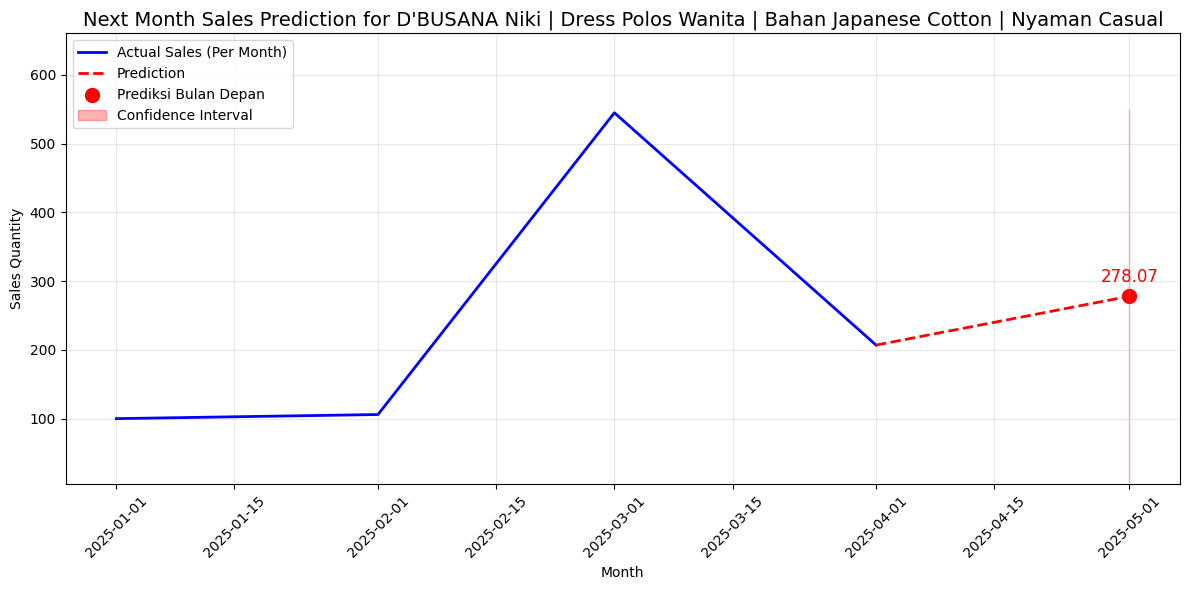

✅ Chart saved: next_month_prediction_D'BUSANA Niki | Dress Polos Wanita | Bahan Japanese Cotton | Nyaman Casual.png
📝 Summary added to: prediction_summary_D'BUSANA Niki | Dress Polos Wanita | Bahan Japanese Cotton | Nyaman Casual.txt


In [ ]:
# Prediksi bulan depan
last_date = created_times.iloc[train_size + valid_size + len(X_test) - 1]
product_name = product_names.iloc[train_size + valid_size + len(X_test) - 1]

next_month_period = (pd.to_datetime(last_date) + pd.DateOffset(months=1)).to_period("M")
next_month = next_month_period.to_timestamp()

test_dates = created_times.iloc[train_size + valid_size : train_size + valid_size + len(X_test)]

# Filter test data untuk bulan saat ini
current_month_period = pd.to_datetime(last_date).to_period("M")
mask_current_month = test_dates.dt.to_period("M") == current_month_period
X_current_month = X_test[mask_current_month]

if X_current_month.empty:
    X_current_month = X_test
    current_month_avg_daily = np.expm1(y_test).mean()
else:
    y_pred_log_current = model_optimized.predict(X_current_month)
    current_month_avg_daily = np.expm1(y_pred_log_current).mean()

# Dapatkan data penjualan bulanan historis
actual_test_df = pd.DataFrame({
    'Date': test_dates.reset_index(drop=True),
    'Sales': np.expm1(y_test).values,
    'Product_Name': product_names.iloc[train_size + valid_size : train_size + valid_size + len(X_test)].values
})
actual_test_df = actual_test_df[actual_test_df['Product_Name'] == product_name]
actual_test_df['year_month'] = actual_test_df['Date'].dt.to_period('M')
monthly_actual = actual_test_df.groupby('year_month')['Sales'].sum().reset_index()
monthly_actual['year_month'] = monthly_actual['year_month'].dt.to_timestamp()

# Analisis tren historis untuk faktor musiman
if len(monthly_actual) >= 3:
    last_3_months = monthly_actual.tail(3)
    monthly_sales = last_3_months['Sales'].values

    growth_rates = [monthly_sales[i] / monthly_sales[i-1] for i in range(1, len(monthly_sales)) if monthly_sales[i-1] > 0]
    seasonal_factor = np.mean(growth_rates) if growth_rates else 1.0
    seasonal_factor = max(0.7, min(seasonal_factor, 1.3))
elif len(monthly_actual) == 2:
    growth_rate = monthly_actual['Sales'].iloc[1] / monthly_actual['Sales'].iloc[0] if monthly_actual['Sales'].iloc[0] > 0 else 1.0
    seasonal_factor = max(0.7, min(growth_rate, 1.3))
else:
    seasonal_factor = 1.0

# Hitung prediksi untuk bulan depan
if not monthly_actual.empty:
    last_month_total = monthly_actual['Sales'].iloc[-1]
    days_in_next_month = pd.Period(next_month_period).days_in_month
    days_in_current_month = pd.Period(current_month_period).days_in_month
    days_ratio = days_in_next_month / days_in_current_month
    next_month_pred_total = last_month_total * seasonal_factor * days_ratio
else:
    days_in_next_month = pd.Period(next_month_period).days_in_month
    next_month_pred_total = current_month_avg_daily * days_in_next_month

# Pastikan prediksi masuk akal
if not monthly_actual.empty:
    min_reasonable = last_month_total * 0.7
    max_reasonable = last_month_total * 1.5
    next_month_pred_total = max(min_reasonable, min(next_month_pred_total, max_reasonable))

# Hitung interval kepercayaan
if len(monthly_actual) >= 3:
    historical_std = monthly_actual['Sales'].std()
    y_pred_test_opt = model_optimized.predict(X_test)
    rmse_test_opt = np.sqrt(mean_squared_error(y_test, y_pred_test_opt))
    prediction_std = (rmse_test_opt + historical_std * 0.5) * seasonal_factor
else:
    prediction_std = rmse_test_opt * np.sqrt(days_in_next_month) * seasonal_factor

ci_lower = max(0, next_month_pred_total - prediction_std * 2)
ci_upper = next_month_pred_total + prediction_std * 2

# Tampilkan hasil prediksi
print(f"\nPrediction for {next_month_period.strftime('%B %Y')} with {days_in_next_month} days.")
print(f"Predicted total sales: {next_month_pred_total:.2f} units")
print(f"Confidence interval: {ci_lower:.2f} - {ci_upper:.2f}")

# Visualisasi prediksi bulan depan
plt.figure(figsize=(12, 6))

plt.plot(monthly_actual['year_month'], monthly_actual['Sales'], 'b-', label='Actual Sales (Per Month)', linewidth=2)
plt.plot([monthly_actual['year_month'].iloc[-1], next_month],
         [monthly_actual['Sales'].iloc[-1], next_month_pred_total],
         'r--', label='Prediction', linewidth=2)
plt.scatter(next_month, next_month_pred_total, color='red', s=100, label='Prediksi Bulan Depan')
plt.fill_between([next_month], [ci_lower], [ci_upper], color='red', alpha=0.3, label='Confidence Interval')

plt.annotate(f"{next_month_pred_total:.2f}",
             (next_month, next_month_pred_total),
             textcoords="offset points", xytext=(0, 10), ha='center', fontsize=12, color='red')

plt.title(f'Next Month Sales Prediction for {product_name}', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Sales Quantity')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.tight_layout()

y_min = max(0, min(ci_lower, min(monthly_actual['Sales'])) * 0.8)
y_max = max(ci_upper, max(monthly_actual['Sales'])) * 1.2
plt.ylim(y_min, y_max)

plt.savefig(f'next_month_prediction_{product_name}.png', dpi=300)
plt.show()

# Simpan laporan
with open(f'prediction_summary_{product_name}.txt', 'a') as f:
    f.write("\nNEXT MONTH SALES PREDICTION\n")
    f.write(f"- Predicted month: {next_month.strftime('%Y-%m')}\n")
    f.write(f"- Predicted sales: {next_month_pred_total:.2f}\n")
    f.write(f"- Confidence Interval: {ci_lower:.2f} to {ci_upper:.2f}\n")
    f.write(f"- Historical growth factor: {seasonal_factor:.2f}\n")
    f.write(f"- Days in month adjustment: {days_ratio:.2f}\n")

print(f"✅ Chart saved: next_month_prediction_{product_name}.png")
print(f"📝 Summary added to: prediction_summary_{product_name}.txt")